# Example 02: PyTorch DataLoader

## 事前準備

In [1]:
import torch

# GPUが使えるか確認してデバイスを設定
# NOTE: `x = x.to(device) ` とすることで対象のデバイスに切り替え可能
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 自動微分

In [2]:
import torch
from tqdm.notebook import tqdm

### requires_grad属性

Tensorのrequires_grad属性をTrueにすることで、各要素の勾配が自動微分の計算対象となる。  
また、requires_grad属性をTrueの場合、Tensorの演算をすることで、grad_fnが記録される。

In [3]:
x = torch.ones(2, 3, requires_grad=True)
x

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)

In [4]:
y = x + 2
y

tensor([[3., 3., 3.],
        [3., 3., 3.]], grad_fn=<AddBackward0>)

### 勾配の自動計算

In [5]:
a = torch.tensor([1.0], requires_grad=True)
b = a * 2

# 逆伝搬
b.backward()

# b = 2 * a をaで微分するため、結果は2となる
a.grad

tensor([2.])

## DataLoader

In [6]:
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

### MNISTデータセット取得

In [7]:
# 画像幅、高さ
img_size = 28

# 訓練データ
mnist_train = MNIST(
    "../cache/data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# 検証データ
mnist_test = MNIST(
    "../cache/data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print(f"n_train: {len(mnist_train)}, n_test: {len(mnist_test)}")

n_train: 60000, n_test: 10000


### DataLoaderの設定

In [8]:
batch_size = 128

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

### モデル構築

In [9]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(img_size * img_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, img_size * img_size)     # 画像を1次元に変換
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)

### 学習

In [11]:
%%time
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

record_loss_train = []
record_loss_test = []

n_epochs = 10
verbose = 1

for epoch in tqdm(range(n_epochs)):
    net.train()     # 訓練モード
    loss_train = 0

    # ミニバッチ取得(train)
    for j, (x, t) in enumerate(train_loader):
        x, t = x.to(device), t.to(device)
        y = net(x)

        loss = loss_func(y, t)
        loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= j + 1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0

    # ミニバッチ取得(test)
    for j, (x, t) in enumerate(test_loader):
        x, t = x.to(device), t.to(device)
        y = net(x)

        loss = loss_func(y, t)
        loss_test += loss.item()

    loss_test /= j + 1
    record_loss_test.append(loss_test)

    if epoch % verbose == 0:
        print(f"Epoch: {epoch}, loss_train: {loss_train}, loss_test: {loss_test}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, loss_train: 2.026443415867494, loss_test: 1.4496136722685415
Epoch: 1, loss_train: 0.9287951439936787, loss_test: 0.6094602719892429
Epoch: 2, loss_train: 0.5296355740093728, loss_test: 0.4403693290262283
Epoch: 3, loss_train: 0.4236749505945869, loss_test: 0.3735469566021539
Epoch: 4, loss_train: 0.375251441558541, loss_test: 0.3403047542028789
Epoch: 5, loss_train: 0.3464033162352373, loss_test: 0.3178580661268928
Epoch: 6, loss_train: 0.32574120135322565, loss_test: 0.3015084633297181
Epoch: 7, loss_train: 0.30962558112927335, loss_test: 0.2869477497437332
Epoch: 8, loss_train: 0.2959507561123956, loss_test: 0.27753278881877286
Epoch: 9, loss_train: 0.2840567644534589, loss_test: 0.2655311071702951
CPU times: user 27.2 s, sys: 1.14 s, total: 28.4 s
Wall time: 27.2 s


### 誤差の推移

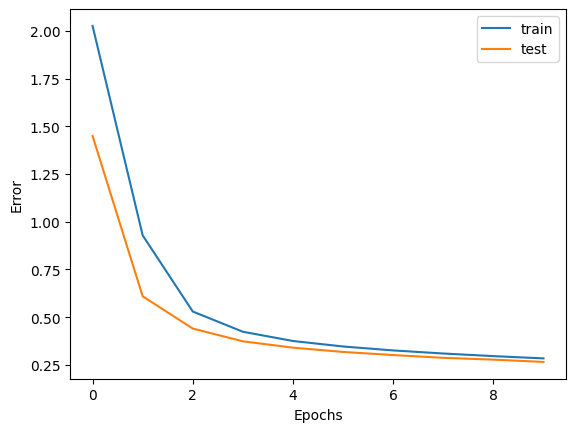

In [12]:
plt.plot(record_loss_train, label="train")
plt.plot(record_loss_test, label="test")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()

### 正答率算出

In [13]:
correct = 0
total = 0

net.eval()

for i, (x, t) in enumerate(test_loader):
    x, t = x.to(device), t.to(device)
    y = net(x)

    correct += (y.argmax(1) == t).sum().item()
    total += len(x)

print(f"Accuracy: {correct / total}")

Accuracy: 0.9237
